In [1]:
from src.data.data_helper import get_raw_data_as_dataframe, segment_data

In [2]:
ANN_v1_path      = r"C:\Users\erik\IES_codebase\EMG_Project\CDT406-Smart-Gripper\models\ANN_search\best_ANN_models\ANN_variant_1.keras"
ANN_v2_path      = r"C:\Users\erik\IES_codebase\EMG_Project\CDT406-Smart-Gripper\models\ANN_search\best_ANN_models\ANN_variant_2.keras"
ANN_STFT_v3_path = r"C:\Users\erik\IES_codebase\EMG_Project\CDT406-Smart-Gripper\models\ANN_STFT_search\best_ANN_STFT_models\ANN_STFT_variant_3.keras"

In [3]:
from tensorflow.keras.models import load_model
from src.models.model_components.stft_layer import STFTLayer

# Load the models
model_ANN_v1 = load_model(ANN_v1_path)
model_ANN_v2 = load_model(ANN_v2_path)
model_ANN_STFT_v3 = load_model(
    ANN_STFT_v3_path,
    custom_objects={"STFTLayer": STFTLayer}
)

print("Models successfully loaded.")


Models successfully loaded.


In [4]:
from src.models.model_components.preprocessor import SignalPreprocessor
import pandas as pd
import tensorflow as tf
import numpy as np

def get_training_data(pre_processor_variant=1):
    raw_train, raw_val = get_raw_data_as_dataframe(validation_subjects=(1,2,3,4,5,6,7,8,9,10))

    pre_processor = SignalPreprocessor(pre_processor_variant=pre_processor_variant,
                                       low_freq=20.0,
                                       high_freq=500.0,
                                       fs=5000.0,
                                       order=7,
                                       down_sample=True)

    window_length = 200 * 5  # 200 ms
    overlap = 50 * 5
    seg_train = segment_data(raw_train, window_length=window_length, overlap=overlap)
    seg_val = segment_data(raw_val, window_length=window_length, overlap=overlap)

    all_labels = pd.concat([seg_train['label'], seg_val['label']])
    num_classes = all_labels.nunique()
    y_train = tf.keras.utils.to_categorical(seg_train['label'], num_classes)
    y_val = tf.keras.utils.to_categorical(seg_val['label'], num_classes)

    X_train = np.stack(seg_train.drop(columns=['label', 'source'])['window_data'].values)
    X_val = np.stack(seg_val.drop(columns=['label', 'source'])['window_data'].values)
    X_train = pre_processor.batch_pre_process(X_train)
    X_val = pre_processor.batch_pre_process(X_val)

    # For ANN, we need to flatten the input if it's multidimensional
    if len(X_train.shape) > 2:
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_val = X_val.reshape(X_val.shape[0], -1)

    input_shape = X_train.shape[1]
    return X_train, y_train, X_val, y_val, num_classes, input_shape

In [5]:
import numpy as np
from sklearn.metrics import f1_score

def evaluate_model_per_class_f1(model, pre_processor_variant):
    # Import data using get_training_data
    _, _, X_val, y_val, num_classes, _ = get_training_data(pre_processor_variant=pre_processor_variant)

    # Predict on validation data
    y_val_pred_prob = model.predict(X_val)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    # Compute per-class F1 score
    per_class_f1 = f1_score(y_val_true, y_val_pred, average=None)

    return per_class_f1[:4]

In [6]:
per_class_f1_ANN_v1 = evaluate_model_per_class_f1(model_ANN_v1, pre_processor_variant=1)

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [7]:
per_class_f1_ANN_v2 = evaluate_model_per_class_f1(model_ANN_v2, pre_processor_variant=2)

339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [8]:
per_class_f1_ANN_STFT_v3 = evaluate_model_per_class_f1(model_ANN_STFT_v3, pre_processor_variant=3)

339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


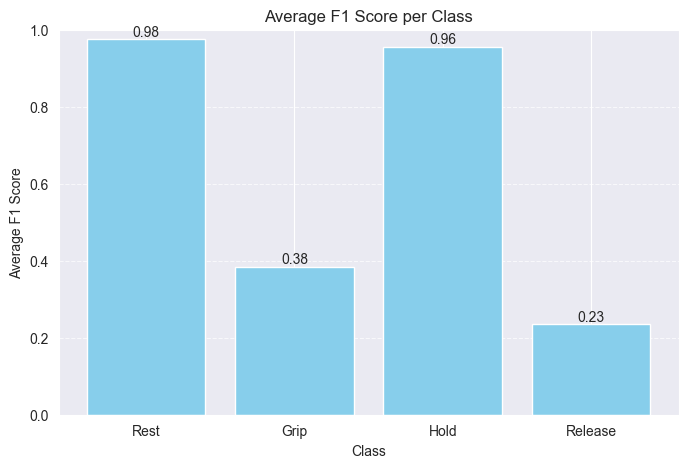

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# F1 scores for the three models
f1_scores = {
    "ANN_v1": per_class_f1_ANN_v1,
    "ANN_v2": per_class_f1_ANN_v2,
    "ANN_STFT_v3": per_class_f1_ANN_STFT_v3
}

# Calculate the average F1 score for each class
f1_scores_per_class = np.mean(list(f1_scores.values()), axis=0)

# Plot the average F1 scores per class
plt.figure(figsize=(8, 5))
bars = plt.bar(range(1, len(f1_scores_per_class) + 1), f1_scores_per_class, color='skyblue')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.title("Average F1 Score per Class")
plt.ylabel("Average F1 Score")
plt.xlabel("Class")
plt.ylim(0, 1)  # Assuming F1 scores are between 0 and 1
plt.xticks(range(1, len(f1_scores_per_class) + 1), labels=["Rest", "Grip", "Hold", "Release"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()